# DataLab Cup 4: Recommender Systems

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tqdm import tqdm
from collections import defaultdict

from evaluation.environment import TrainingEnvironment, TestingEnvironment

2024-01-15 03:06:06.930832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


2024-01-15 03:06:07.864239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-15 03:06:07.864411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-15 03:06:07.868448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-15 03:06:07.868588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-15 03:06:07.868680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Hyper Parameters

In [3]:
# Official hyperparameters for this competition (do not modify)
N_TRAIN_USERS = 1000
N_TEST_USERS = 2000
N_ITEMS = 209527
HORIZON = 2000
TEST_EPISODES = 5
SLATE_SIZE = 5


# parameters
MODEL_PATH = "./model_NN"
CKP_DIR = "./checkpoints/NN"

# FunkSVD hyperparameters
EMBEDDING_SIZE = 50
BATCH_SIZE = 128
INITIAL_N_EPOCHS = 100
N_EPOCHS = 25
LEARNING_RATE = 5e-5
TRAINING_EPISODES = 500


# Q-learning
# agent
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5

# training
NUM_EPISODE = 40000
PRINT_EVERY_EPISODE = 500

## Datasets

In [4]:
# Dataset paths
USER_DATA = os.path.join('dataset', 'user_data.json')
ITEM_DATA = os.path.join('dataset', 'item_data.json')
USER_ITEM_SIMILARITY = os.path.join('dataset', 'user_item_similarity.pkl')
INTERACT_DATA = os.path.join('dataset', 'organized_interact_data.pkl')

# Output file path
OUTPUT_PATH = os.path.join('output', 'output.csv')

## User Data

In [5]:
df_user = pd.read_json(USER_DATA, lines=True)
df_user

,user_id,history
0,0,"[42558, 65272, 13353]"
1,1,"[146057, 195688, 143652]"
2,2,"[67551, 85247, 33714]"
3,3,"[116097, 192703, 103229]"
4,4,"[68756, 140123, 135289]"
...,...,...
1995,1995,"[95090, 131393, 130239]"
1996,1996,"[2360, 147130, 8145]"
1997,1997,"[99794, 138694, 157888]"
1998,1998,"[55561, 60372, 51442]"


## Item Data

In [6]:
df_item = pd.read_json(ITEM_DATA, lines=True)
df_item

,item_id,headline,short_description
0,0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...
1,1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...
2,2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha..."
3,3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to..."
4,4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...
...,...,...,...
209522,209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...
209523,209523,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr..."
209524,209524,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked..."
209525,209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...


In [7]:
df_user_item_sim = pd.read_pickle(USER_ITEM_SIMILARITY)
df_user_item_sim

,0,1,2,3,4,5,6,7,8,9,...,209517,209518,209519,209520,209521,209522,209523,209524,209525,209526
0,0.062287,0.003323,0.261205,0.274883,0.064868,0.013853,0.226747,0.061278,0.196566,0.109174,...,0.043999,0.059647,0.192302,0.062932,0.180494,0.012018,0.048684,0.079522,-0.015544,0.075266
1,0.221764,0.055316,0.112049,0.190925,0.091024,0.078525,0.017141,0.173482,0.051898,0.018566,...,-0.004871,-0.035946,0.117543,-0.005578,0.029166,0.013565,0.055716,0.008542,0.073230,0.038990
2,0.106126,0.022207,0.117865,0.251699,-0.012615,-0.014647,0.126634,0.021103,0.089571,0.015671,...,0.036220,0.084124,-0.012249,0.043811,0.079477,-0.061269,0.037820,0.004233,0.000226,0.029401
3,0.093782,0.016448,0.107896,0.075283,0.067360,-0.035875,0.099989,0.168689,0.128790,0.098932,...,0.056915,0.040844,0.170552,0.072513,0.178354,0.060635,0.035779,0.203117,0.084404,0.080729
4,0.122536,0.071247,0.153996,0.225814,0.183863,0.045011,0.210932,0.074886,0.209297,0.033176,...,0.063099,0.134406,0.060474,0.110714,0.092821,0.012666,0.129592,0.059556,0.067587,0.003772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.100583,0.015665,0.170305,0.348556,0.004256,0.037536,0.147794,0.190394,0.262166,0.082865,...,0.060153,0.081491,0.119582,0.026745,0.165972,0.012540,0.067981,0.044060,-0.026443,-0.015400
1996,0.091208,0.042278,0.095109,0.068298,0.088406,0.037034,0.087014,0.329571,0.112063,0.101930,...,-0.045567,-0.018176,0.064000,0.040877,0.201333,0.011241,0.077976,0.176499,0.095174,0.040855
1997,0.084990,0.107297,0.142880,0.165294,0.093537,0.032139,0.144430,0.103643,0.136623,0.098574,...,0.043109,-0.038939,0.077905,0.010034,0.133854,0.056863,0.035067,0.070287,0.059929,0.019807
1998,0.170120,0.071936,0.222804,0.198526,0.098436,-0.000620,0.210958,0.153454,0.097726,0.120007,...,0.026999,0.008165,0.022288,0.071645,0.013865,0.025776,0.133728,0.029238,0.022635,0.013028


In [8]:
df_interact_data = pd.read_pickle(INTERACT_DATA)
df_interact_data

,user_id,item_id,rating
0,0,12126,5
1,0,9810,5
2,0,42558,1
3,0,13353,1
4,0,9102,5
...,...,...,...
796164,999,199848,1
796165,999,134616,1
796166,999,53478,1
796167,999,110229,1


## NN

In [9]:
class RecommenderModel(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size=50, hidden_units=128, learning_rate=1e-4):
        super(RecommenderModel, self).__init__()
        self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

        self.user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, input_length=1)
        self.item_embedding = Embedding(input_dim=num_items, output_dim=embedding_size, input_length=1)
        self.flatten = Flatten()
        self.concat = Concatenate()
        self.mlp_layer_1 = Dense(64, activation='relu')
        self.mlp_layer_2 = Dense(32, activation='relu')
        self.hidden_layer = Dense(hidden_units, activation='relu')
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_input, item_input = inputs
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        user_flat = self.flatten(user_embedded)
        item_flat = self.flatten(item_embedded)
        merged = self.concat([user_flat, item_flat])
        mlp_output = self.mlp_layer_2(self.mlp_layer_1(merged))
        merged_with_mlp = self.concat([merged, mlp_output])
        hidden = self.hidden_layer(merged_with_mlp)
        output = self.output_layer(hidden)
        return output
    
    @tf.function
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        '''
        Compute the MSE loss of the model
        '''
        loss = tf.losses.mean_squared_error(y_true, y_pred)

        return loss

    @tf.function  # the function decorated by tf.function will be compiled into a callable TensorFlow graph automatically. This allows the TensorFlow runtime to apply optimizations and exploit parallelism to boost computation performance.
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # training=True is only needed if there are layers with different
            # behavior during training versus inference (e.g. Dropout).

            user_ids = tf.cast(data[:, 0], dtype=tf.int32)
            item_ids = tf.cast(data[:, 1], dtype=tf.int32)
            y_true = tf.cast(data[:, 2], dtype=tf.float32)

            y_pred = self([user_ids, item_ids])
            loss = self.compute_loss(y_true, y_pred)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss
    

    @tf.function
    def val_step(self, data):
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        y_pred = self([user_ids, item_ids])
        loss = self.compute_loss(y_true, y_pred)

        return loss

### Training Data

In [10]:
temp = []
for i in range(N_TEST_USERS):
    for item in df_user.iloc[i]["history"]:
        temp.append([df_user["user_id"][i], item, 5])

    sorted_indices = np.argsort(df_user_item_sim.iloc[i])[::-1]
    for item in sorted_indices[:10]:
        temp.append([df_user["user_id"][i], item, 5])
    for item in sorted_indices[10:100]:
        temp.append([df_user["user_id"][i], item, 4])
    # for item in sorted_indices[100:1000]:
    #     temp.append([df_user["user_id"][i], item, 3])

df_augmentation = pd.DataFrame(temp, columns=["user_id", "item_id", "rating"])
df_augmentation

,user_id,item_id,rating
0,0,42558,5
1,0,65272,5
2,0,13353,5
3,0,13353,5
4,0,42558,5
...,...,...,...
205995,1999,119308,4
205996,1999,98758,4
205997,1999,115028,4
205998,1999,133118,4


In [11]:
df_ratings = pd.concat([df_augmentation, df_interact_data], axis=0, ignore_index=True)
df_ratings

,user_id,item_id,rating
0,0,42558,5
1,0,65272,5
2,0,13353,5
3,0,13353,5
4,0,42558,5
...,...,...,...
1002164,999,199848,1
1002165,999,134616,1
1002166,999,53478,1
1002167,999,110229,1


In [12]:
train_dataframes = []
val_dataframes = []

for i in tqdm(range(N_TEST_USERS)):
    user_all = df_ratings[df_ratings['user_id'] == i]
    user_train = user_all.iloc[3:]
    user_val = user_all.iloc[:3]
    # assert len(user_train) == 100
    assert len(user_val) == 3
    train_dataframes.append(user_train)
    val_dataframes.append(user_val)

100%|██████████| 2000/2000 [00:00<00:00, 2092.49it/s]


In [13]:
# concat all per-user training sets
df_train = pd.concat(train_dataframes, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
df_train_norm = df_train.copy(deep=True)
df_train_norm['rating'] -= 3
df_train_norm['rating'] /= 2
df_train_norm

,user_id,item_id,rating
0,0,13353,1.0
1,0,42558,1.0
2,0,65272,1.0
3,0,9810,1.0
4,0,9102,1.0
...,...,...,...
996164,1999,119308,0.5
996165,1999,98758,0.5
996166,1999,115028,0.5
996167,1999,133118,0.5


In [14]:
# concat all per-user validation sets
df_val = pd.concat(val_dataframes, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
# here we make a copy of the un-normalized validation set for evaluation
df_val_norm = df_val.copy(deep=True)
df_val_norm['rating'] -= 3
df_val_norm['rating'] /= 2
df_val_norm

,user_id,item_id,rating
0,0,42558,1.0
1,0,65272,1.0
2,0,13353,1.0
3,1,146057,1.0
4,1,195688,1.0
...,...,...,...
5995,1998,60372,1.0
5996,1998,51442,1.0
5997,1999,125409,1.0
5998,1999,77906,1.0


In [15]:
# prepare datasets
dataset_train = tf.data.Dataset.from_tensor_slices(df_train_norm)
dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE, drop_remainder=True)\
                             .prefetch(buffer_size=tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices(df_val_norm)
dataset_val = dataset_val.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE, drop_remainder=True)\
                         .prefetch(buffer_size=tf.data.AUTOTUNE)

### Evaluation Metric

In [16]:
@tf.function
def log2(x: tf.Tensor) -> tf.Tensor:
    return tf.math.log(tf.cast(x, tf.float32)) / tf.math.log(2.)

@tf.function
def ndcg_at_5(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:5]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return 1. / log2(2 + tf.argmax(idx))
    else:
        return tf.constant(0.)

@tf.function
def recall_at_5(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:5]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return tf.constant(1.)
    else:
        return tf.constant(0.)

def evaluate(model: tf.keras.Model, dataset: tf.data.Dataset) -> tuple:
    '''
    For each data point in the dataset:
    data[0] is the UserID
    data[1] is the ItemID 
    data[2] is the Rating
    '''
    ndcg_scores = []
    recall_scores = []

    for data in tqdm(dataset, desc='Evaluating'):
        # query the model to make predictions if the observed event is a positive interaction (ratings >= 4)
        if data[2] >= 4:
            y_pred = model.eval_predict_onestep(tf.gather(data, 0))
            # print(f"y_pred:{y_pred}")
            y_true = tf.gather(data, 1)
            # print(f"y_true:{y_true}")
            ndcg = ndcg_at_5(y_true, y_pred)
            recall = recall_at_5(y_true, y_pred)
            ndcg_scores.append(ndcg)
            recall_scores.append(recall)

    ndcg_result = tf.reduce_mean(ndcg_scores).numpy()
    recall_result = tf.reduce_mean(recall_scores).numpy()

    return ndcg_result, recall_result

### Initial the model

In [17]:
# build the model
model = RecommenderModel(num_users=N_TEST_USERS, num_items=N_ITEMS, embedding_size=EMBEDDING_SIZE, learning_rate=LEARNING_RATE)

In [18]:
ckp = tf.train.latest_checkpoint(CKP_DIR)
if ckp:
    init_epoch = (int(ckp.split('-')[-1]))
    ckpt = tf.train.Checkpoint(epoch=tf.Variable(init_epoch), model=model)
    ckpt.restore(ckp)
    print(f'Resume training from epoch {init_epoch}')
else:
    init_epoch = 1
    ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), model=model)
    print(f'Start training from epoch {init_epoch}')

manager = tf.train.CheckpointManager(ckpt, CKP_DIR, max_to_keep=3, checkpoint_name='NN')

Resume training from epoch 13


In [19]:
# train the model
train_losses = []
val_losses = []

for epoch in range(1, INITIAL_N_EPOCHS + 1):
    ckpt.epoch.assign_add(1)

    train_loss = []
    val_loss = []

    # training
    for data in dataset_train:
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # validating
    for data in dataset_val:
        loss = model.val_step(data)
        val_loss.append(loss.numpy())

    # record losses
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}')

    # save checkpoint
    save_path = manager.save()
    if save_path:
        print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2024-01-15 03:07:06.471341: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1 train_loss: 0.8331, val_loss: 0.4374
Saved checkpoint for epoch 14: ./checkpoints/NN/NN-14
Epoch 2 train_loss: 0.8331, val_loss: 0.4532
Saved checkpoint for epoch 15: ./checkpoints/NN/NN-15
Epoch 3 train_loss: 0.8331, val_loss: 0.4919
Saved checkpoint for epoch 16: ./checkpoints/NN/NN-16
Epoch 4 train_loss: 0.8330, val_loss: 0.4858
Saved checkpoint for epoch 17: ./checkpoints/NN/NN-17
Epoch 5 train_loss: 0.8330, val_loss: 0.4548
Saved checkpoint for epoch 18: ./checkpoints/NN/NN-18
Epoch 6 train_loss: 0.8330, val_loss: 0.4682
Saved checkpoint for epoch 19: ./checkpoints/NN/NN-19
Epoch 7 train_loss: 0.8330, val_loss: 0.4884
Saved checkpoint for epoch 20: ./checkpoints/NN/NN-20
Epoch 8 train_loss: 0.8330, val_loss: 0.5105
Saved checkpoint for epoch 21: ./checkpoints/NN/NN-21
Epoch 9 train_loss: 0.8330, val_loss: 0.5433
Saved checkpoint for epoch 22: ./checkpoints/NN/NN-22
Epoch 10 train_loss: 0.8330, val_loss: 0.5498
Saved checkpoint for epoch 23: ./checkpoints/NN/NN-23
Epoch 11 

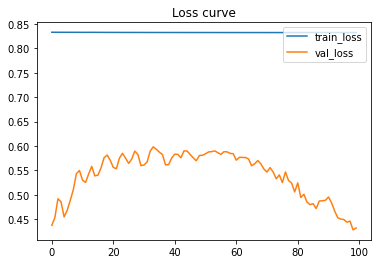

In [20]:
# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

### Evaluate the model with the training set and validation set

In [21]:
dataset_train = tf.data.Dataset.from_tensor_slices(df_train)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_train)
print(f'Evaluation result: [NDCG@5: {ndcg_result:.6f}, Recall@5: {recall_result:.6f}]')

Evaluating:   0%|          | 0/996169 [00:00<?, ?it/s]


AttributeError: 'RecommenderModel' object has no attribute 'eval_predict_onestep'

: 

In [ ]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@5: {ndcg_result:.6f}, Recall@5: {recall_result:.6f}]')

## Simulation Environments

## Training

In [ ]:
# Initialize the training environment
train_env = TrainingEnvironment()
train_scores = []


interact_data = []
# Repeat the testing process for 5 times
for i in range(TRAINING_EPISODES):
    print(f'Episode {i+1}:')

    # Start the training process
    # Run as long as there exist some active users
    while train_env.has_next_state():
        # Get the current user id
        cur_user = train_env.get_state()
        # print(f'The current user is user {cur_user}.')

        # [TODO] Employ your recommendation policy to generate a slate of 5 distinct items
        slate = model.eval_predict_onestep(cur_user)

        # Get the response of the slate from the environment
        clicked_id, in_environment = train_env.get_response(slate)
        # print(f'The click result of recommending {slate} to user {cur_user} is {f"item {clicked_id}" if clicked_id != -1 else f"{clicked_id} (no click)"}.')
        # print(f'User {cur_user} {"is still in" if in_environment else "leaves"} the environment.')

        if clicked_id == -1:
            for item in slate:
                random_number = random.choice([1, 2, 3])
                interact_data.append([cur_user, item.numpy(), random_number])
        else:
            interact_data.append([cur_user, clicked_id, 5])

        # [TODO] Update your model here (optional)
        ACCUMULATIVE_DATA_SIZE = 100*BATCH_SIZE
        if len(interact_data) >= ACCUMULATIVE_DATA_SIZE:
            print(f'Updating Model')
            df_interact = pd.DataFrame(interact_data[:ACCUMULATIVE_DATA_SIZE], columns=["user_id", "item_id", "rating"])
            df_interact.to_csv('./interact_data/interact_data.csv', mode='a', header=False, index=False)
            interact_data = interact_data[ACCUMULATIVE_DATA_SIZE:]

            df_interact = pd.concat([df_train, df_interact], axis=0)
            df_interact_norm = df_interact.copy(deep=True)
            df_interact_norm['rating'] -= 3
            df_interact_norm['rating'] /= 2

            dataset_interact = tf.data.Dataset.from_tensor_slices(df_interact_norm)
            dataset_interact = dataset_interact.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)\
                                                .prefetch(buffer_size=tf.data.AUTOTUNE)
            

            # train the model
            train_losses = []
            val_losses = []

            for epoch in range(1, N_EPOCHS + 1):
                train_loss = []
                val_loss = []
                # print(f'Epoch {epoch}:')

                # training
                for data in dataset_interact:
                    loss = model.train_step(data)
                    train_loss.append(loss.numpy())

                # validating
                for data in dataset_val:
                    loss = model.val_step(data)
                    val_loss.append(loss.numpy())

                # record losses
                avg_train_loss = np.mean(train_loss)
                avg_val_loss = np.mean(val_loss)
                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)

                # print losses
                print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}\r', end="")

            print(f'')


    # Record the score of this testing episode
    train_scores.append(train_env.get_score())

    # Reset the training environment (this can be useful when you have finished one episode of simulation and do not want to re-initialize a new environment)
    train_env.reset()
    print(f'Have collected {len(interact_data)} interact data\n')

    # [TODO] Delete or reset your model weights here (in the end of each testing episode)
    # [TODO] Code for deleting your model weights...

In [ ]:
# Calculate the average scores 
avg_scores = [np.average(train_scores) for train_scores in zip(*train_scores)]
df_train_score = pd.DataFrame([[user_id, avg_score] for user_id, avg_score in enumerate(avg_scores)], columns=['user_id', 'avg_score'])
df_train_score

In [ ]:
print(f'training score: {1-(df_train_score["avg_score"].sum()/2000)}')

In [ ]:
# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

### Evaluate the model with the training set and validation set

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices(df_interact)
variable = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_train)
print(f'Evaluation result: [NDCG@5: {ndcg_result:.6f}, Recall@5: {recall_result:.6f}]')

In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices(df_val)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_val)
print(f'Evaluation result: [NDCG@5: {ndcg_result:.6f}, Recall@5: {recall_result:.6f}]')

### Save FunkSVD

In [ ]:
# save the model
model.save_model(MODEL_PATH)

## Testing

In [ ]:
# Initialize the testing environment
test_env = TestingEnvironment()
scores = []

# The item_ids here is for the random recommender
item_ids = [i for i in range(N_ITEMS)]

# Repeat the testing process for 5 times
for _ in range(1):
    # [TODO] Load your model weights here (in the beginning of each testing episode)
    # [TODO] Code for loading your model weights...
    funk_SVD = FunkSVDRecommender(m_users=N_TEST_USERS, n_items=N_ITEMS, embedding_size=EMBEDDING_SIZE, learning_rate=LEARNING_RATE, bias_mu=BIAS_MU)
    funk_SVD.load_model(MODEL_PATH)

    # Start the testing process
    with tqdm(desc='Testing') as pbar:
        # Run as long as there exist some active users
        while test_env.has_next_state():
            # Get the current user id
            cur_user = test_env.get_state()

            # [TODO] Employ your recommendation policy to generate a slate of 5 distinct items
            # [TODO] Code for generating the recommended slate...
            # Here we provide a simple random implementation
            # slate = random.sample(item_ids, k=SLATE_SIZE)
            slate = funk_SVD.eval_predict_onestep(cur_user)

            # Get the response of the slate from the environment
            clicked_id, in_environment = test_env.get_response(slate)

            # [TODO] Update your model here (optional)
            # [TODO] You can update your model at each step, or perform a batched update after some interval
            # [TODO] Code for updating your model...

            




            # Update the progress indicator
            pbar.update(1)

    # Record the score of this testing episode
    scores.append(test_env.get_score())

    # Reset the testing environment
    test_env.reset()

    # [TODO] Delete or reset your model weights here (in the end of each testing episode)
    # [TODO] Code for deleting your model weights...

# Calculate the average scores 
avg_scores = [np.average(score) for score in zip(*scores)]

# Generate a DataFrame to output the result in a .csv file
df_result = pd.DataFrame([[user_id, avg_score] for user_id, avg_score in enumerate(avg_scores)], columns=['user_id', 'avg_score'])
df_result.to_csv(OUTPUT_PATH, index=False)
df_result

In [ ]:
print(f'testing score: {1-(df_result["avg_score"].sum()/2000)}')